In [19]:
# From this point we will start create container for inference
# 
# 
# 
# 
# 
# 

In [1]:
import os
local_package_dir = "./efs/pix2pix_model"  # Directory where local files created
local_model_upload = os.path.join (local_package_dir, "model") # directory where uploaded file structure created
s3_path_to_models = "s3://miro-integration-ml-model-store"
# create and archive model file
my_model_name = "pix2pix-model-0001.tar.gz"



In [6]:
!mkdir ./efs
!mkdir $local_package_dir
!mkdir $local_model_upload
!mkdir $local_model_upload/code/


In [7]:
%%writefile $local_model_upload/code/requirements.txt
pillow
diffusers==0.12.1
transformers==4.26.1
accelerate==0.16.0
safetensors==0.2.8
scipy==1.7.3
--extra-index-url https://download.pytorch.org/whl/cu113
torch==1.11.0+cu113
--extra-index-url https://download.pytorch.org/whl/cu113
torchaudio==0.11.0+cu113
--extra-index-url https://download.pytorch.org/whl/cu113
torchvision==0.12.0+cu113


Writing ./efs/pix2pix_model/model/code/requirements.txt


In [12]:
%%writefile $local_model_upload/code/inference.py

import os, json, random
import pkg_resources
from PIL import Image, ImageOps
from io import BytesIO
import base64, requests
import torch


# Initializations section
from diffusers import StableDiffusionInstructPix2PixPipeline, EulerAncestralDiscreteScheduler


# Helpers: All helpers going here

# Model
# model_fn(model_dir) overrides the default method for loading a model. 
# The return value model will be used in thepredict_fn for predictions.
#     model_dir is the the path to your unzipped model.tar.gz
def model_fn(model_dir):
    # Log start dir
    # Load and return model from dir
    # 
    print ("----- Fanky inference on line: model load. Let's look around first.", )
    # Use the DPMSolverMultistepScheduler (DPM-Solver++) scheduler here instead
    model_id = "timbrooks/instruct-pix2pix"
    pipe = StableDiffusionInstructPix2PixPipeline.from_pretrained(model_id, torch_dtype=torch.float16, safety_checker=None)
    pipe.to("cuda")
    pipe.scheduler = EulerAncestralDiscreteScheduler.from_config(pipe.scheduler.config)


    #installed_packages = pkg_resources.working_set
    #installed_packages_list = sorted(["%s==%s" % (i.key, i.version)
    #   for i in installed_packages])
    #print ("Checking installed packages... \nPackages list: ", installed_packages_list)
    
    
    print ("----- Some fanky model found in my model directory: ", model_dir)
    
    print ("----- Fanky model loaded, see you later ----")
    return pipe

# Data-pre processing
# The return value data will be used in predict_fn for predictions. The inputs are:
#    input_data is the raw body of your request.
#    content_type is the content type from the request header.
#
# def input_fn(input_data, content_type):
    
# Image download helper
def download_image(url):
    image = Image.open(requests.get(url, stream=True).raw)
    image = ImageOps.exif_transpose(image)
    image = image.convert("RGB")
    return image


# Predictor
# predict_fn(processed_data, model) overrides the default method for predictions. 
# The return value predictions will be used in output_fn.
#
#    model returned value from model_fn methond
#    processed_data returned value from input_fn method
#

def predict_fn(data, model): # predict_fn(processed_data, model) # if you have several assets
    # destruct model and tokenizer
    # 
    
    print ("----- Fanky inference on line: predictor")
    print ("Fanky request: ", data)
    prompt = data["prompt"]
    img_url = data["image_url"]
    
    image = download_image(img_url)
    image = model(prompt, image=image, num_inference_steps=10, image_guidance_scale=1).images[0]

    byte_io = BytesIO()
    image.save(byte_io, "JPEG")

    result_string = base64.encodebytes(byte_io.getvalue()).decode("utf-8")
    
    return result_string

# Data post-processing
# The return value result will be the response to your request (e.g.JSON). The inputs are:
#
#    predictions is the result from predict_fn.
#    accept is the return accept type from the HTTP Request, e.g. application/json.
#
#

Overwriting ./efs/pix2pix_model/model/code/inference.py


In [13]:
%%time
# Archive model files & prepare to upload
!tar -cvzf $local_package_dir/$my_model_name --exclude=".ipynb_*" -C $local_model_upload .

./
./code/
./code/requirements.txt
./code/inference.py
CPU times: user 5.45 ms, sys: 6.16 ms, total: 11.6 ms
Wall time: 158 ms


In [14]:
# Upload our model to S3 bucket
import os

full_model_path = os.path.join(s3_path_to_models, my_model_name)
!aws s3 cp $local_package_dir/$my_model_name $full_model_path

upload: efs/pix2pix_model/pix2pix-model-0001.tar.gz to s3://miro-integration-ml-model-store/pix2pix-model-0001.tar.gz


In [1]:
# From here we create SageMaker model and inference endpoint
# 
# 


In [2]:
# Create sagemaker model and run inference endpoint
import sagemaker, boto3, os
from sagemaker.huggingface.model import HuggingFaceModel

full_model_path = os.path.join(s3_path_to_models, my_model_name)

# prepare model execution role
try:
    role = sagemaker.get_execution_role()
except ValueError:
    iam = boto3.client('iam')
    role = iam.get_role(RoleName='sagemaker_execution_role')['Role']['Arn']

# create model
# create Hugging Face Model Class
huggingface_model = HuggingFaceModel(
   model_data=full_model_path,       # path to your model and script
   role=role,                    # iam role with permissions to create an Endpoint
   transformers_version="4.12",  # transformers version used
   pytorch_version="1.9",        # pytorch version used
   py_version='py38',            # python version used
)

print ("Model created: ", huggingface_model)

Model created:  <sagemaker.huggingface.model.HuggingFaceModel object at 0x7fdd4078afe0>


In [3]:
role

'arn:aws:iam::616815736523:role/service-role/AmazonSageMaker-ExecutionRole-20230114T015275'

In [4]:
%%time
# create inference endpoint
# deploy the endpoint endpoint
# Inference types: https://aws.amazon.com/sagemaker/pricing/
instance_type = "ml.g4dn.2xlarge"

predictor = huggingface_model.deploy(
    initial_instance_count=1,
    instance_type=instance_type
    )

------------!CPU times: user 340 ms, sys: 8.98 ms, total: 349 ms
Wall time: 6min 33s


In [5]:
predictor.endpoint

The endpoint attribute has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


'huggingface-pytorch-inference-2023-05-14-08-16-41-000'

In [18]:
%%time
# Test image generation

data = {
    "prompt" : "turn him into cyborg",
    "image_url" : "https://raw.githubusercontent.com/timothybrooks/instruct-pix2pix/main/imgs/example.jpg"
}

result = predictor.predict(data)

CPU times: user 12.6 ms, sys: 0 ns, total: 12.6 ms
Wall time: 3.29 s


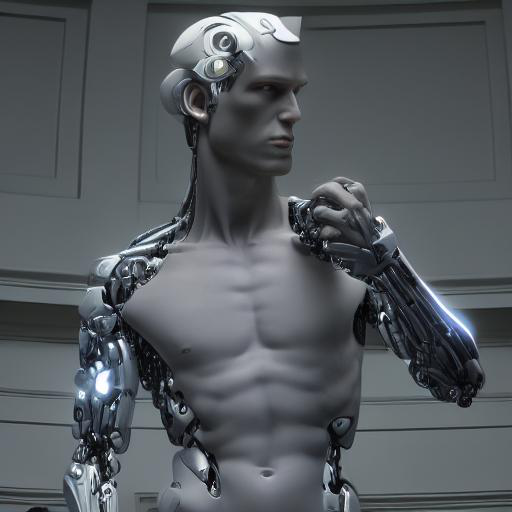

In [19]:
# Create image from result
from io import BytesIO
import base64
from PIL import Image

# What to do with string to make it bytes again
new_byte_io = BytesIO(base64.decodebytes(result.encode("utf-8")))

new_image = Image.open(new_byte_io)
new_image.show()

In [73]:
%%time
import json
ENDPOINT_NAME_MODIFY = "huggingface-pytorch-inference-2023-02-13-22-18-37-649"

runtime = boto3.client('runtime.sagemaker')
parameters = b'{    "action": "modify", "prompt": "turn him into cyborg", "image_url": "https://raw.githubusercontent.com/timothybrooks/instruct-pix2pix/main/imgs/example.jpg"}'
#
print ("Call endpoint: ", ENDPOINT_NAME_MODIFY )
print ("With parameters: ", parameters)
response = runtime.invoke_endpoint(EndpointName=ENDPOINT_NAME_MODIFY,
                                   ContentType='application/json',
                                   Body=parameters)
print ("Received reply from endpoint, len: ", len(response_string))
# What to do with string to make it bytes again
response_image = response["Body"]
stream = response_image.read()
data = json.loads(stream)

Call endpoint:  huggingface-pytorch-inference-2023-02-13-22-18-37-649
With parameters:  b'{    "action": "modify", "prompt": "turn him into cyborg", "image_url": "https://raw.githubusercontent.com/timothybrooks/instruct-pix2pix/main/imgs/example.jpg"}'
Received reply from endpoint, len:  4
CPU times: user 14.7 ms, sys: 3.66 ms, total: 18.3 ms
Wall time: 3.09 s


In [74]:
# base64.encodebytes(byte_io.getvalue()).decode("utf-8")
new_byte_io = BytesIO(base64.decodebytes(data.encode("utf-8")))


In [75]:
new_image = Image.open(new_byte_io)

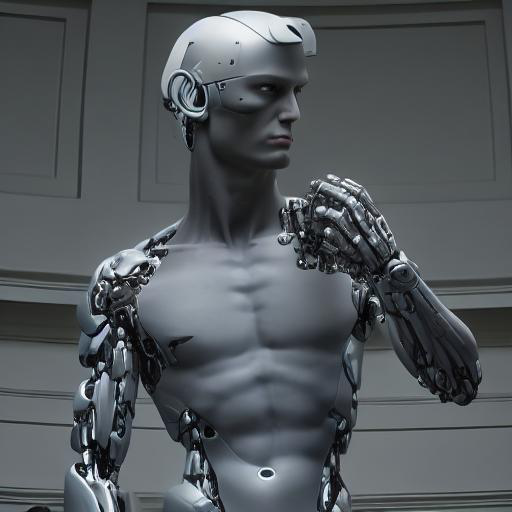

In [76]:
new_image

In [70]:
result

'/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0a\nHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIy\nMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAIAAgADASIA\nAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQA\nAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3\nODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWm\np6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEA\nAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSEx\nBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElK\nU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3\nuLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwDzg28Z\n/hpptYz61CupKfvRMPpUi38J67h9RTJENkvYmmmyPZv0qcXcB/j/ADFOE8R6SL+dAFM2T9sU02kg\n7Voh0PR1P40tFgMs2sg/hNNNu4/hP5Vq0YosBkGJh2P5U3yz6Vs7RSFFPYUWAxv

NoSuchEntityException: An error occurred (NoSuchEntity) when calling the GetRole operation: The role with name sagemaker_execution_role cannot be found.

ClientError: An error occurred (ValidationError) when calling the GetRole operation: The specified value for roleName is invalid. It must contain only alphanumeric characters and/or the following: +=,.@_-

UnknownServiceError: Unknown service: 'sagemaker-metrics'. Valid service names are: accessanalyzer, account, acm, acm-pca, alexaforbusiness, amp, amplify, amplifybackend, amplifyuibuilder, apigateway, apigatewaymanagementapi, apigatewayv2, appconfig, appconfigdata, appflow, appintegrations, application-autoscaling, application-insights, applicationcostprofiler, appmesh, apprunner, appstream, appsync, athena, auditmanager, autoscaling, autoscaling-plans, backup, backup-gateway, batch, braket, budgets, ce, chime, chime-sdk-identity, chime-sdk-meetings, chime-sdk-messaging, cloud9, cloudcontrol, clouddirectory, cloudformation, cloudfront, cloudhsm, cloudhsmv2, cloudsearch, cloudsearchdomain, cloudtrail, cloudwatch, codeartifact, codebuild, codecommit, codedeploy, codeguru-reviewer, codeguruprofiler, codepipeline, codestar, codestar-connections, codestar-notifications, cognito-identity, cognito-idp, cognito-sync, comprehend, comprehendmedical, compute-optimizer, config, connect, connect-contact-lens, connectparticipant, cur, customer-profiles, databrew, dataexchange, datapipeline, datasync, dax, detective, devicefarm, devops-guru, directconnect, discovery, dlm, dms, docdb, drs, ds, dynamodb, dynamodbstreams, ebs, ec2, ec2-instance-connect, ecr, ecr-public, ecs, efs, eks, elastic-inference, elasticache, elasticbeanstalk, elastictranscoder, elb, elbv2, emr, emr-containers, es, events, evidently, finspace, finspace-data, firehose, fis, fms, forecast, forecastquery, frauddetector, fsx, gamelift, glacier, globalaccelerator, glue, grafana, greengrass, greengrassv2, groundstation, guardduty, health, healthlake, honeycode, iam, identitystore, imagebuilder, importexport, inspector, inspector2, iot, iot-data, iot-jobs-data, iot1click-devices, iot1click-projects, iotanalytics, iotdeviceadvisor, iotevents, iotevents-data, iotfleethub, iotsecuretunneling, iotsitewise, iotthingsgraph, iottwinmaker, iotwireless, ivs, kafka, kafkaconnect, kendra, keyspaces, kinesis, kinesis-video-archived-media, kinesis-video-media, kinesis-video-signaling, kinesisanalytics, kinesisanalyticsv2, kinesisvideo, kms, lakeformation, lambda, lex-models, lex-runtime, lexv2-models, lexv2-runtime, license-manager, lightsail, location, logs, lookoutequipment, lookoutmetrics, lookoutvision, machinelearning, macie, macie2, managedblockchain, marketplace-catalog, marketplace-entitlement, marketplacecommerceanalytics, mediaconnect, mediaconvert, medialive, mediapackage, mediapackage-vod, mediastore, mediastore-data, mediatailor, memorydb, meteringmarketplace, mgh, mgn, migration-hub-refactor-spaces, migrationhub-config, migrationhubstrategy, mobile, mq, mturk, mwaa, neptune, network-firewall, networkmanager, nimble, opensearch, opsworks, opsworkscm, organizations, outposts, panorama, personalize, personalize-events, personalize-runtime, pi, pinpoint, pinpoint-email, pinpoint-sms-voice, polly, pricing, proton, qldb, qldb-session, quicksight, ram, rbin, rds, rds-data, redshift, redshift-data, rekognition, resiliencehub, resource-groups, resourcegroupstaggingapi, robomaker, route53, route53-recovery-cluster, route53-recovery-control-config, route53-recovery-readiness, route53domains, route53resolver, rum, s3, s3control, s3outposts, sagemaker, sagemaker-a2i-runtime, sagemaker-edge, sagemaker-featurestore-runtime, sagemaker-runtime, savingsplans, schemas, sdb, secretsmanager, securityhub, serverlessrepo, service-quotas, servicecatalog, servicecatalog-appregistry, servicediscovery, ses, sesv2, shield, signer, sms, sms-voice, snow-device-management, snowball, sns, sqs, ssm, ssm-contacts, ssm-incidents, sso, sso-admin, sso-oidc, stepfunctions, storagegateway, sts, support, swf, synthetics, textract, timestream-query, timestream-write, transcribe, transfer, translate, voice-id, waf, waf-regional, wafv2, wellarchitected, wisdom, workdocs, worklink, workmail, workmailmessageflow, workspaces, workspaces-web, xray

UnknownServiceError: Unknown service: 'sagemaker-metrics'. Valid service names are: accessanalyzer, account, acm, acm-pca, alexaforbusiness, amp, amplify, amplifybackend, amplifyuibuilder, apigateway, apigatewaymanagementapi, apigatewayv2, appconfig, appconfigdata, appflow, appintegrations, application-autoscaling, application-insights, applicationcostprofiler, appmesh, apprunner, appstream, appsync, athena, auditmanager, autoscaling, autoscaling-plans, backup, backup-gateway, batch, braket, budgets, ce, chime, chime-sdk-identity, chime-sdk-meetings, chime-sdk-messaging, cloud9, cloudcontrol, clouddirectory, cloudformation, cloudfront, cloudhsm, cloudhsmv2, cloudsearch, cloudsearchdomain, cloudtrail, cloudwatch, codeartifact, codebuild, codecommit, codedeploy, codeguru-reviewer, codeguruprofiler, codepipeline, codestar, codestar-connections, codestar-notifications, cognito-identity, cognito-idp, cognito-sync, comprehend, comprehendmedical, compute-optimizer, config, connect, connect-contact-lens, connectparticipant, cur, customer-profiles, databrew, dataexchange, datapipeline, datasync, dax, detective, devicefarm, devops-guru, directconnect, discovery, dlm, dms, docdb, drs, ds, dynamodb, dynamodbstreams, ebs, ec2, ec2-instance-connect, ecr, ecr-public, ecs, efs, eks, elastic-inference, elasticache, elasticbeanstalk, elastictranscoder, elb, elbv2, emr, emr-containers, es, events, evidently, finspace, finspace-data, firehose, fis, fms, forecast, forecastquery, frauddetector, fsx, gamelift, glacier, globalaccelerator, glue, grafana, greengrass, greengrassv2, groundstation, guardduty, health, healthlake, honeycode, iam, identitystore, imagebuilder, importexport, inspector, inspector2, iot, iot-data, iot-jobs-data, iot1click-devices, iot1click-projects, iotanalytics, iotdeviceadvisor, iotevents, iotevents-data, iotfleethub, iotsecuretunneling, iotsitewise, iotthingsgraph, iottwinmaker, iotwireless, ivs, kafka, kafkaconnect, kendra, keyspaces, kinesis, kinesis-video-archived-media, kinesis-video-media, kinesis-video-signaling, kinesisanalytics, kinesisanalyticsv2, kinesisvideo, kms, lakeformation, lambda, lex-models, lex-runtime, lexv2-models, lexv2-runtime, license-manager, lightsail, location, logs, lookoutequipment, lookoutmetrics, lookoutvision, machinelearning, macie, macie2, managedblockchain, marketplace-catalog, marketplace-entitlement, marketplacecommerceanalytics, mediaconnect, mediaconvert, medialive, mediapackage, mediapackage-vod, mediastore, mediastore-data, mediatailor, memorydb, meteringmarketplace, mgh, mgn, migration-hub-refactor-spaces, migrationhub-config, migrationhubstrategy, mobile, mq, mturk, mwaa, neptune, network-firewall, networkmanager, nimble, opensearch, opsworks, opsworkscm, organizations, outposts, panorama, personalize, personalize-events, personalize-runtime, pi, pinpoint, pinpoint-email, pinpoint-sms-voice, polly, pricing, proton, qldb, qldb-session, quicksight, ram, rbin, rds, rds-data, redshift, redshift-data, rekognition, resiliencehub, resource-groups, resourcegroupstaggingapi, robomaker, route53, route53-recovery-cluster, route53-recovery-control-config, route53-recovery-readiness, route53domains, route53resolver, rum, s3, s3control, s3outposts, sagemaker, sagemaker-a2i-runtime, sagemaker-edge, sagemaker-featurestore-runtime, sagemaker-runtime, savingsplans, schemas, sdb, secretsmanager, securityhub, serverlessrepo, service-quotas, servicecatalog, servicecatalog-appregistry, servicediscovery, ses, sesv2, shield, signer, sms, sms-voice, snow-device-management, snowball, sns, sqs, ssm, ssm-contacts, ssm-incidents, sso, sso-admin, sso-oidc, stepfunctions, storagegateway, sts, support, swf, synthetics, textract, timestream-query, timestream-write, transcribe, transfer, translate, voice-id, waf, waf-regional, wafv2, wellarchitected, wisdom, workdocs, worklink, workmail, workmailmessageflow, workspaces, workspaces-web, xray